## Import libraries and define constants and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
HBAR = 6.582e-16  # Planck constant divided by 2π, in eV·s
A0 = 5.46836113565  # Bohr radius in Angstroms
A = 4*A0
A_CM = A*1e-8  # Unit: cm
DK = 2*np.pi/A_CM  # Unit: cm^-1
MASS_ELEC = 9.1093837015e-31 # kg
EV_TO_J = 1.60218e-19

In [2]:
# Function to calculate Gaussian
def gaussian(x, sigma, mu):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

In [3]:
# Function to perform Gaussian smearing based on group velocity
def gaussian_smearing_with_vg(x, y, vgs,scale):
    sigmas = [HBAR * vg * DK*scale for vg in vgs]  # Calculate sigmas based on group velocities
    smeared_y = np.zeros_like(y)
    for i, xi in enumerate(x):
        new_y = 0
        tot_wt = 0
        for y_i, sigma, mu in zip(y, sigmas, x):
            if sigma != 0:
                wt = gaussian(xi, sigma, mu)
            else:
                wt = 0.0
            new_y += wt * y_i
            tot_wt += wt
        smeared_y[i] = new_y / tot_wt
    return smeared_y

## Define data

In [4]:
num_k_points = 27
isp = 1

Read in the plotting energy from the energy table files for all k-points.

In [5]:
ENERGY_PATH = '../CrossSectionCalculations/SiVH3/GaNPaper/posToNeut/EnergyTabulator/'

dEPlot = []

# Read transition rates and energies for each k-point
for ik in range(num_k_points):    
    file_path = f'{ENERGY_PATH}/energyTable.{isp}.{ik+1}'
    energyTable_k = np.loadtxt(file_path, skiprows=8)
    dEPlot.append(energyTable_k[:,5])

        
dEPlot = np.array(dEPlot)

Read in the zeroth-order transition rate for all k-points.

In [6]:
RATE0_PATH = '../CrossSectionCalculations/SiVH3/GaNPaper/posToNeut/zerothOrder/LSF/'

transitionRate0 = []

# Read transition rates and energies for each k-point
for ik in range(num_k_points):
    file_path = f'{RATE0_PATH}/transitionRate.{isp}.{ik+1}'
    transitionRate_k = np.loadtxt(file_path, skiprows=5)
    transitionRate0.append(transitionRate_k[:,2])

        
transitionRate0 = np.array(transitionRate0)

Read in the zeroth-order matrix elements for all k-points.

In [7]:
ME0_PATH = '../CrossSectionCalculations/SiVH3/GaNPaper/posToNeut/zerothOrder/TME/'

ME0 = []

# Read matrix elements for each k-point
for ik in range(num_k_points):
    file_path = f'{ME0_PATH}/allElecOverlap.{isp}.{ik+1}'
    ME0_k = np.loadtxt(file_path, skiprows=6)
    ME0.append(ME0_k[:,5])

        
ME0 = np.array(ME0).flatten()

Read in the gamma-only, first-order transition rate.

In [8]:
RATE1_PATH = '../CrossSectionCalculations/SiVH3/GaNPaper/posToNeut/firstOrder/LSF/'

file_path = f'{RATE1_PATH}/transitionRate.{isp}.1.eCorrExcOneRef'
transitionRate_full = np.loadtxt(file_path, skiprows=5)
transitionRate1 = np.array(transitionRate_full[:,2])

Read in the group-velocity information.

In [9]:
GVEL_PATH = '../CrossSectionCalculations/SiVH3/GaNPaper/VASPAndExport/pristine/groupVelocity/'

file_path = f'{GVEL_PATH}/gVelByPatt.txt'
gVelByPatt = np.array(np.loadtxt(file_path, skiprows=1))
gVelByPatt[gVelByPatt < 1e7] = 0.0

file_path = f'{GVEL_PATH}/kTypeIndex.txt'
kTypeIndex = np.array(np.loadtxt(file_path)).astype(int)

## Calculate cross section

In [10]:
cellVol = 1.0465e-20 # cm^3

In [11]:
sigma0PosToNeut = []
vg = []

for ik in range(num_k_points):
    sigma0PosToNeut_k = transitionRate0[ik]*cellVol/gVelByPatt[:,kTypeIndex[ik]]
    
    sigma0PosToNeut.append(sigma0PosToNeut_k)
    vg.append(gVelByPatt[:,kTypeIndex[ik]])

#print(sigma0PosToNeut)
sigma0PosToNeut = np.array(sigma0PosToNeut).flatten()
sigma0PosToNeut[sigma0PosToNeut == np.inf] = 0.0

vg = np.array(vg).flatten()

/tmp/ipykernel_365/3530433040.py:5: RuntimeWarning: divide by zero encountered in divide
  sigma0PosToNeut_k = transitionRate0[ik]*cellVol/gVelByPatt[:,kTypeIndex[ik]]


In [12]:
sigma0PosToNeut[:10]

array([2.43360637e-17, 1.16885897e-17, 4.12902853e-17, 1.32740171e-17,
       3.62112258e-18, 6.21352715e-17, 6.30954973e-23, 1.07298362e-22,
       2.89840004e-17, 1.07088063e-18])

In [13]:
sigma1PosToNeut = transitionRate1*cellVol/gVelByPatt[:,0]
sigma1PosToNeut[sigma1PosToNeut == np.inf] = 0.0

/tmp/ipykernel_365/2758867138.py:1: RuntimeWarning: divide by zero encountered in divide
  sigma1PosToNeut = transitionRate1*cellVol/gVelByPatt[:,0]


## Smear and plot data

In [14]:
dEPlotFlat = dEPlot.flatten()

In [15]:
# Sort by increasing energy
sort_indices = np.argsort(dEPlotFlat)
dEPlotFlat_sorted = np.array(dEPlotFlat.tolist())[sort_indices]
sigma0PosToNeut_sorted = np.array(sigma0PosToNeut.tolist())[sort_indices]
vg_sorted = np.array(vg.tolist())[sort_indices]
ME0_sorted = np.array(ME0.tolist())[sort_indices]

In [56]:
# Smear raw data points
#smeared_sigma_vg_neutToNeg = gaussian_smearing_with_vg(dEPlot, sigma0NeutToNeg, vg,0.4)
smeared_sigma0_vg_posToNeut = gaussian_smearing_with_vg(dEPlotFlat_sorted, sigma0PosToNeut_sorted, vg_sorted,1.0/3.0)
smeared_sigma1_vg_posToNeut = gaussian_smearing_with_vg(dEPlot[0], sigma1PosToNeut, gVelByPatt[:,0],1)

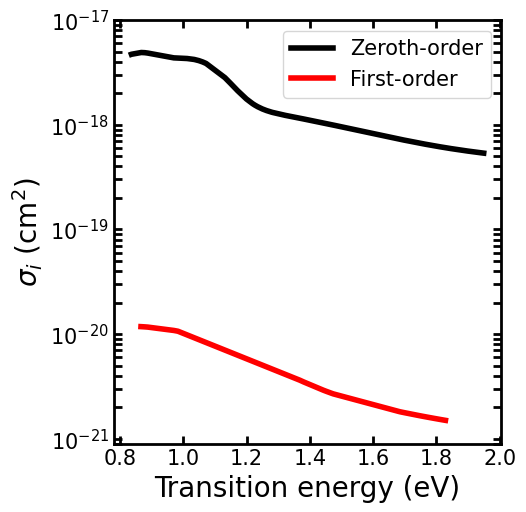

In [59]:
plt.figure(figsize=(5,5.5))

# Paper figure with smeared results
plt.semilogy(dEPlotFlat_sorted, smeared_sigma0_vg_posToNeut, color='black', label='Zeroth-order', linewidth=4)#, marker='o', markersize=10)
plt.semilogy(dEPlot[0], smeared_sigma1_vg_posToNeut, color='red', label='First-order', linewidth=4)#, marker='o', markersize=10)

# Raw data
#plt.semilogy(dEPlot, sigma0PosToNeut, color='black', label='Zeroth-order', marker='o', linestyle='', markersize=10)
#plt.semilogy(dEPlot, sigma1PosToNeut, color='red', label='First-order', marker='s', linestyle='', markersize=10)
#plt.plot(dEPlot, sigma0PosToNeut, color='black', label='Raw', marker='s', markersize=10, linestyle='None')

# Labels
plt.xlabel('Transition energy (eV)', fontsize=20)
plt.ylabel('$\sigma_i$ (cm$^2$)', fontsize=20)

# Plot formatting
plt.legend(loc='upper right', fontsize=15)  # Move the legend to the top right and increase font size
plt.xticks(fontsize=15)  # Increase x-axis tick font size
plt.yticks(fontsize=15)  # Increase y-axis tick font size
plt.ylim(0.9e-21,1e-17)
ax = plt.gca()
ax.spines['top'].set_linewidth(2.0)   # Top border
ax.spines['right'].set_linewidth(2.0) # Right border
ax.spines['bottom'].set_linewidth(2.0)  # Bottom border (default width)
ax.spines['left'].set_linewidth(2.0)    # Left border (default width)
ax.tick_params(axis='both',  # Apply to both x and y axes
               which='both',  # Apply to both major and minor ticks
               direction='in',  # Tick direction (inward and outward)
               width=2,  # Thickness of the tick marks
               length=6, # Length of the tick marks
               bottom=True, top=True, left=True, right=True)  
plt.show()

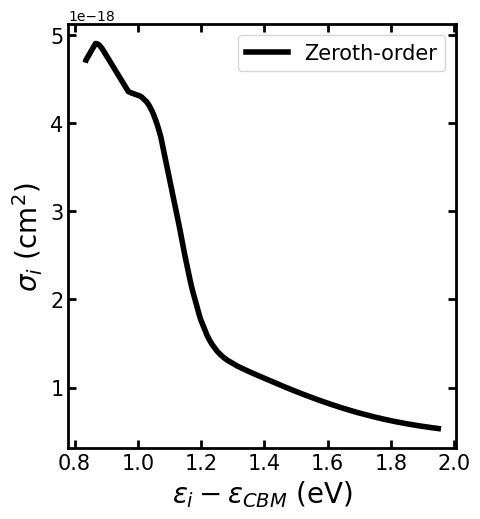

In [58]:
plt.figure(figsize=(5,5.5))

# Paper figure with smeared results
plt.plot(dEPlotFlat_sorted, smeared_sigma0_vg_posToNeut, color='black', label='Zeroth-order', linewidth=4)#, marker='o', markersize=10)

# Labels
plt.xlabel('$\epsilon_i - \epsilon_{CBM}$ (eV)', fontsize=20)
plt.ylabel('$\sigma_i$ (cm$^2$)', fontsize=20)

# Plot formatting
plt.legend(loc='upper right', fontsize=15)  # Move the legend to the top right and increase font size
plt.xticks(fontsize=15)  # Increase x-axis tick font size
plt.yticks(fontsize=15)  # Increase y-axis tick font size
#plt.ylim(0.9e-21,1e-17)
ax = plt.gca()
ax.spines['top'].set_linewidth(2.0)   # Top border
ax.spines['right'].set_linewidth(2.0) # Right border
ax.spines['bottom'].set_linewidth(2.0)  # Bottom border (default width)
ax.spines['left'].set_linewidth(2.0)    # Left border (default width)
ax.tick_params(axis='both',  # Apply to both x and y axes
               which='both',  # Apply to both major and minor ticks
               direction='in',  # Tick direction (inward and outward)
               width=2,  # Thickness of the tick marks
               length=6, # Length of the tick marks
               bottom=True, top=True, left=True, right=True)  
plt.show()

### Matrix elements

In [18]:
smeared_ME0_vg_posToNeut = gaussian_smearing_with_vg(dEPlotFlat_sorted, ME0_sorted, vg_sorted,0.22)

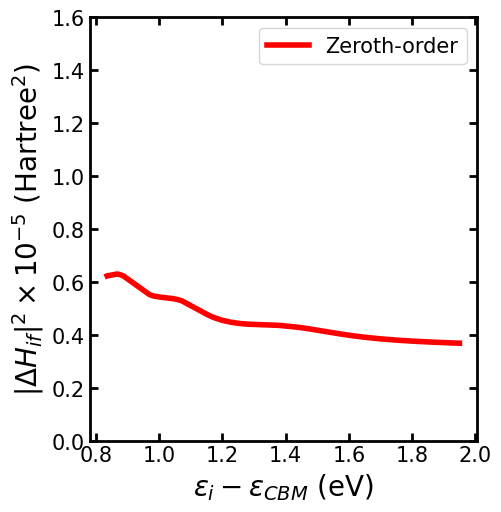

In [35]:
# Plot the smeared curve
plt.figure(figsize=(5,5.5))
plt.plot(dEPlotFlat_sorted, smeared_ME0_vg_posToNeut/1e-5, color='red', label='Zeroth-order',linewidth=4)
plt.xlabel(r'$\epsilon_i - \epsilon_{CBM}$ (eV)', fontsize=20)
plt.ylabel(r'$|\Delta H_{if}|^2 \times 10^{-5}$ (Hartree$^2$)', fontsize=20)
plt.legend(loc='upper right', fontsize=15)  # Move the legend to the top right and increase font size
plt.xticks(fontsize=15)  # Increase x-axis tick font size
plt.yticks(fontsize=15)  # Increase y-axis tick font size
plt.ylim(0,1.6)
ax = plt.gca()
ax.spines['top'].set_linewidth(2.0)   # Top border
ax.spines['right'].set_linewidth(2.0) # Right border
ax.spines['bottom'].set_linewidth(2.0)  # Bottom border (default width)
ax.spines['left'].set_linewidth(2.0)    # Left border (default width)
ax.tick_params(axis='both',  # Apply to both x and y axes
               which='both',  # Apply to both major and minor ticks
               direction='in',  # Tick direction (inward and outward)
               width=2,  # Thickness of the tick marks
               length=6, # Length of the tick marks
               bottom=True, top=True, left=True, right=True)  
plt.show()

### Compare with Barmparis

Calculate a classical velocity by shifting our energy up 0.32 eV to approximate the numbers used in the Barmparis paper.

In [36]:
vg_classical = np.sqrt(2*(dEPlotFlat_sorted)*EV_TO_J/MASS_ELEC)*1e2

In [37]:
vg_classical

array([54236442.97530057, 54236442.97651965, 54236539.87584233, ...,
       82812367.0578065 , 82812499.93543084, 82812499.9354945 ])

In [38]:
def gaussian_smearing(x, y, sigma):
    smearing = np.exp(-(x[:, np.newaxis] - x[np.newaxis, :]) ** 2 / (2 * sigma ** 2))
    smeared_y = np.sum(smearing * y, axis=1) / np.sum(smearing, axis=1)
    return smeared_y

In [39]:
vg_smeared = gaussian_smearing(dEPlotFlat_sorted, vg_sorted, 0.1)

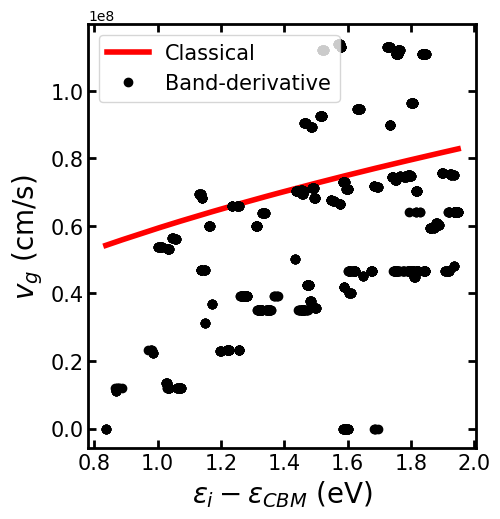

In [40]:
plt.figure(figsize=(5,5.5))
plt.plot(dEPlotFlat_sorted, vg_classical, color='red', label='Classical',linewidth=4)
plt.plot(dEPlotFlat_sorted, vg_sorted, color='black', label='Band-derivative',marker='o',linestyle='None')
plt.xlabel(r'$\epsilon_i - \epsilon_{CBM}$ (eV)', fontsize=20)
plt.ylabel(r'$v_g$ (cm/s)', fontsize=20)
plt.legend(loc='upper left', fontsize=15)  # Move the legend to the top right and increase font size
plt.xticks(fontsize=15)  # Increase x-axis tick font size
plt.yticks(fontsize=15)  # Increase y-axis tick font size
#plt.ylim(0,7)
ax = plt.gca()
ax.spines['top'].set_linewidth(2.0)   # Top border
ax.spines['right'].set_linewidth(2.0) # Right border
ax.spines['bottom'].set_linewidth(2.0)  # Bottom border (default width)
ax.spines['left'].set_linewidth(2.0)    # Left border (default width)
ax.tick_params(axis='both',  # Apply to both x and y axes
               which='both',  # Apply to both major and minor ticks
               direction='in',  # Tick direction (inward and outward)
               width=2,  # Thickness of the tick marks
               length=6, # Length of the tick marks
               bottom=True, top=True, left=True, right=True)  
plt.show()

Divide by our matrix element and multiply by the matrix element used in the Barmparis paper.

In [31]:
transitionRate0Flat = transitionRate0.flatten()/ME0*0.3e-5

In [32]:
transitionRate0Flat_sorted = np.array(transitionRate0Flat.tolist())[sort_indices]
sigma0Classical = transitionRate0Flat_sorted*cellVol/vg_classical
sigma0Classical[sigma0Classical == np.inf] = 0.0

In [45]:
smeared_sigma0_vgClass = gaussian_smearing_with_vg(dEPlotFlat_sorted, sigma0Classical, vg_classical,0.1)

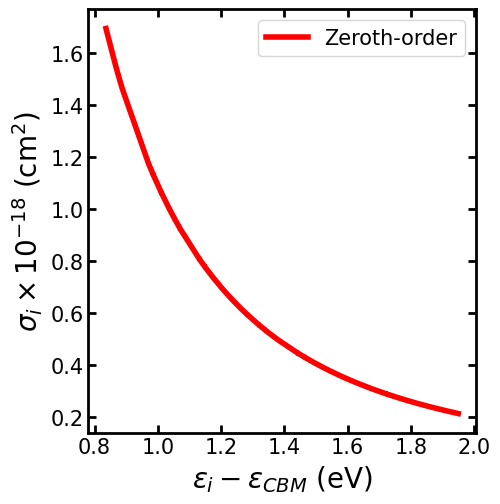

In [49]:
# Plot the smeared curve
plt.figure(figsize=(5,5.5))
#plt.plot(dEPlotFlat_sorted, smeared_sigma0_vg_posToNeut/1e-18, color='red', label='Zeroth-order',linewidth=4)
plt.plot(dEPlotFlat_sorted, sigma0Classical/1e-18, color='red', label='Zeroth-order',linewidth=4)
#plt.plot(dEPlotFlat_sorted, smeared_sigma0_vgClass/1e-19, color='red', label='Zeroth-order',linewidth=4)
plt.xlabel(r'$\epsilon_i - \epsilon_{CBM}$ (eV)', fontsize=20)
plt.ylabel(r'$\sigma_i \times 10^{-18}$ (cm$^2$)', fontsize=20)
plt.legend(loc='upper right', fontsize=15)  # Move the legend to the top right and increase font size
plt.xticks(fontsize=15)  # Increase x-axis tick font size
plt.yticks(fontsize=15)  # Increase y-axis tick font size
#plt.ylim(0,7)
#plt.xlim(0.3,0.7)
ax = plt.gca()
ax.spines['top'].set_linewidth(2.0)   # Top border
ax.spines['right'].set_linewidth(2.0) # Right border
ax.spines['bottom'].set_linewidth(2.0)  # Bottom border (default width)
ax.spines['left'].set_linewidth(2.0)    # Left border (default width)
ax.tick_params(axis='both',  # Apply to both x and y axes
               which='both',  # Apply to both major and minor ticks
               direction='in',  # Tick direction (inward and outward)
               width=2,  # Thickness of the tick marks
               length=6, # Length of the tick marks
               bottom=True, top=True, left=True, right=True)  
plt.show()